In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
manga_df = pd.read_csv('../data/processed_comic.csv')
manga_df.head()

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Status,Genres,Author,Recommended,Mixed Feelings,Not Recommended,Release date,Time from release (months)
0,Berserk,9.47,331288,1,1,665300,122841,4.0,23.0,Publishing,"['Action', 'Adventure', 'Award Winning', 'Dram...",['Miura Kentarou Studio Gaga'],233,15,10,1989-08-25,411
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,156368,2,26,256146,42864,24.0,96.0,Finished,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Araki Hirohiko'],120,7,1,2004-01-19,87
2,Vagabond,9.24,136403,3,15,364891,40158,37.0,327.0,On Hiatus,"['Action', 'Adventure', 'Award Winning']",['Inoue Takehiko Yoshikawa Eiji'],88,8,1,1998-09-03,201
3,One Piece,9.22,366668,4,3,599278,114531,4.0,23.0,Publishing,"['Action', 'Adventure', 'Fantasy']",['Oda Eiichiro'],173,17,16,1997-07-22,316
4,Monster,9.15,93945,5,29,236355,20501,18.0,162.0,Finished,"['Award Winning', 'Drama', 'Mystery']",['Urasawa Naoki'],64,7,5,1994-12-05,84


In [3]:
# Bước 1: Xử lý cột "Genres"
# Tách các nhãn và sử dụng One-Hot Encoding
genres = manga_df['Genres'].str.get_dummies(sep=', ')
manga_df = pd.concat([manga_df, genres], axis=1)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# shuffle dataset
# manga_df = manga_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Bước 2: Xử lý cột "Status"
# Sử dụng Label Encoding hoặc One-Hot Encoding
le = LabelEncoder()
manga_df['Status'] = le.fit_transform(manga_df['Status'])

# Chọn các cột số để làm đặc trưng
numeric_columns = ['Vote', 'Popularity', 'Members', 'Favorite', 'Volumes','Chapters', 'Recommended', 'Mixed Feelings', 'Not Recommended', 'Status']

# Chọn cột 'Score' làm biến mục tiêu
target_column = 'Score'

# Lọc dữ liệu
data = manga_df[numeric_columns + list(genres.columns) + [target_column]].dropna()

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Chia dữ liệu thành tập huấn luyện và tập temp (tổng cộng tập test và validation)
X_train, X_temp, y_train, y_temp = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

# Chia tập temp thành tập test và tập validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Hàm để thực hiện cross-validation và tính trung bình lỗi
def cross_val(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    return -mse.mean()

# Huấn luyện các mô hình và đánh giá chúng
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

scaler = StandardScaler()

# Tạo pipeline để tự động thực hiện chuẩn hóa và huấn luyện mô hình
numeric_features = numeric_columns + list(genres.columns)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features)
    ])

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    pipeline.fit(X_train, y_train)
    
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    
    print(f'{name} Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'{name} Test Accuracy: {test_accuracy * 100:.2f}%')




Linear Regression Train Accuracy: 50.70%
Linear Regression Test Accuracy: -213618517759394486157312.00%
Random Forest Train Accuracy: 95.61%
Random Forest Test Accuracy: 70.75%
XGBoost Train Accuracy: 92.62%
XGBoost Test Accuracy: 68.21%


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

# Chia dữ liệu thành features và target
X = data.drop(target_column, axis=1).values
y = data[target_column].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Chia thành tập train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Chuyển dữ liệu thành Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Xây dựng mô hình
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hàm huấn luyện mô hình
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.3f}')

# Hàm tính score
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            true_labels.extend(labels.numpy())

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    return mse, r2


# Tạo và huấn luyện mô hình
input_size = X_train.shape[1]
model = RegressionModel(input_size)
train_model(model, train_loader, val_loader)

# Đánh giá trên tập train
train_mse, train_r2 = evaluate_model(model, train_loader)
print(f'Train Mean Squared Error: {train_mse:.3f}, Train R^2 Score: {train_r2:.3f}')

# Đánh giá trên tập validation
val_mse, val_r2 = evaluate_model(model, val_loader)
print(f'Validation Mean Squared Error: {val_mse:.3f}, Validation R^2 Score: {val_r2:.3f}')

# Đánh giá trên tập test
test_mse, test_r2 = evaluate_model(model, test_loader)
print(f'Test Mean Squared Error: {test_mse:.3f}, Test R^2 Score: {test_r2:.3f}')


Epoch 1/50, Validation Loss: 292.531
Epoch 2/50, Validation Loss: 48.990
Epoch 3/50, Validation Loss: 10.072
Epoch 4/50, Validation Loss: 7.605
Epoch 5/50, Validation Loss: 6.518
Epoch 6/50, Validation Loss: 5.653
Epoch 7/50, Validation Loss: 5.015
Epoch 8/50, Validation Loss: 4.527
Epoch 9/50, Validation Loss: 4.215
Epoch 10/50, Validation Loss: 4.003
Epoch 11/50, Validation Loss: 3.816
Epoch 12/50, Validation Loss: 3.721
Epoch 13/50, Validation Loss: 3.566
Epoch 14/50, Validation Loss: 3.488
Epoch 15/50, Validation Loss: 3.495
Epoch 16/50, Validation Loss: 3.415
Epoch 17/50, Validation Loss: 3.487
Epoch 18/50, Validation Loss: 3.367
Epoch 19/50, Validation Loss: 3.368
Epoch 20/50, Validation Loss: 3.355
Epoch 21/50, Validation Loss: 3.333
Epoch 22/50, Validation Loss: 3.316
Epoch 23/50, Validation Loss: 3.353
Epoch 24/50, Validation Loss: 3.358
Epoch 25/50, Validation Loss: 3.323
Epoch 26/50, Validation Loss: 3.454
Epoch 27/50, Validation Loss: 3.311
Epoch 28/50, Validation Loss: 3.4

In [11]:
manga_df= pd.read_csv('../data/processed_comic.csv')
test_manga_df = manga_df.iloc[:,1:9]
test_manga_df

,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters
0,9.47,331288,1,1,665300,122841,4.0,23.0
1,9.30,156368,2,26,256146,42864,24.0,96.0
2,9.24,136403,3,15,364891,40158,37.0,327.0
3,9.22,366668,4,3,599278,114531,4.0,23.0
4,9.15,93945,5,29,236355,20501,18.0,162.0
...,...,...,...,...,...,...,...,...
6123,6.91,632,9856,9083,1878,7,4.0,23.0
6124,6.91,488,9857,12964,1159,1,1.0,5.0
6125,6.91,218,9860,11610,1354,12,6.0,31.0
6126,6.91,137,9862,14815,954,9,10.0,23.0


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

3676 1226 1226
Epoch 1/200 - Train Loss: 59.59334373474121, Validation Loss: 59.54508590698242
Epoch 2/200 - Train Loss: 58.61746268436826, Validation Loss: 58.52839660644531
Epoch 3/200 - Train Loss: 57.65076295260725, Validation Loss: 57.55698776245117
Epoch 4/200 - Train Loss: 56.74341280706997, Validation Loss: 56.61804962158203
Epoch 5/200 - Train Loss: 55.86326572812837, Validation Loss: 55.69930648803711
Epoch 6/200 - Train Loss: 54.964044702464136, Validation Loss: 54.79875946044922
Epoch 7/200 - Train Loss: 54.09021857689167, Validation Loss: 53.92060089111328
Epoch 8/200 - Train Loss: 53.26505871476798, Validation Loss: 53.054229736328125
Epoch 9/200 - Train Loss: 52.424735628325365, Validation Loss: 52.20804214477539
Epoch 10/200 - Train Loss: 51.607887531148975, Validation Loss: 51.36515426635742
Epoch 11/200 - Train Loss: 50.78139601082638, Validation Loss: 50.55229187011719
Epoch 12/200 - Train Loss: 49.97828384925579, Validation Loss: 49.74338912963867
Epoch 13/200 - Tra

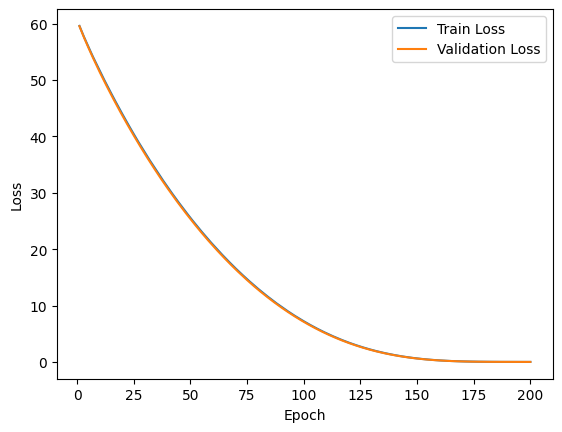

Mean Squared Error on Test Set: 0.019901374657355288, 0.8808805223147711


In [21]:
X_train, X_test, y_train, y_test = train_test_split(test_manga_df.drop('Score', axis=1), test_manga_df['Score'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train), len(X_test), len(X_val))
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors and create DataLoader
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define your linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize model, loss function, optimizer
model = LinearRegressionModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()

# Choose your optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
train_losses = []
val_losses = []
best_model = None
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_loss}, Validation Loss: {val_loss.item()}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
# Plot the training and validation losses over epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.load_state_dict(best_model)
# Test the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_mse = mean_squared_error(y_test, test_outputs.numpy())
    test_r2 = r2_score(y_test, test_outputs.numpy())
print(f'Mean Squared Error on Test Set: {test_mse}, {test_r2}')